# 开始

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os, sys
os.chdir('/content/drive/MyDrive/1cylinder')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# import meshio
import numpy as np
from scipy import stats
import os, sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import time

from copy import deepcopy as cp
from sklearn.linear_model import Lasso
from scipy.integrate import solve_ivp
from math import sqrt
from joblib import Parallel, delayed

from copy import deepcopy as cp
import numpy as np
from sklearn.decomposition import PCA

import pandas as pd
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Add, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import os, sys
import urllib.request

from autoencoder import *

In [ ]:
sys.path.append('/content/drive/MyDrive/1cylinder/scr/')
from utils_plot import *  # contour
from utils_sindy import *
from loops import *
from process import *
from autoencoder import *

# one cylinder





## 1 Load data

In [ ]:
store_path = '/content/drive/MyDrive/1cylinder/data/'
Un = np.load(os.path.join(store_path, "Un.npy"), mmap_mode='r')
Vn = np.load(os.path.join(store_path, "Vn.npy"), mmap_mode='r')
xn = np.load(os.path.join(store_path, "Xncor.npy"), mmap_mode='r')
yn = np.load(os.path.join(store_path, "Yncor.npy"), mmap_mode='r')
Nx, Ny = 128, 64

### contour

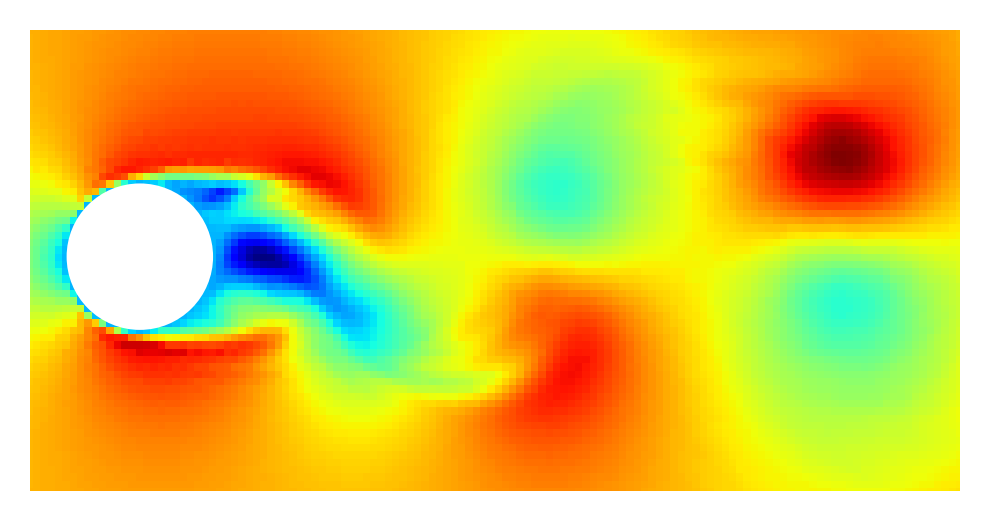

In [ ]:
contour(Un[1000,:,:],'jet',None,xn,yn)

In [ ]:
coordinates = np.zeros((len(xn),len(yn),2))
xx, yy = np.meshgrid(xn,yn)
coordinates[:,:,0], coordinates[:,:,1] = np.array(xx).T, np.array(yy).T

In [ ]:
print(xn)
print(yn)

[ 8.25  8.3   8.35  8.4   8.45  8.5   8.55  8.6   8.65  8.7   8.75  8.8
  8.85  8.9   8.95  9.    9.05  9.1   9.15  9.2   9.25  9.3   9.35  9.4
  9.45  9.5   9.55  9.6   9.65  9.7   9.75  9.8   9.85  9.9   9.95 10.
 10.05 10.1  10.15 10.2  10.25 10.3  10.35 10.4  10.45 10.5  10.55 10.6
 10.65 10.7  10.75 10.8  10.85 10.9  10.95 11.   11.05 11.1  11.15 11.2
 11.25 11.3  11.35 11.4  11.45 11.5  11.55 11.6  11.65 11.7  11.75 11.8
 11.85 11.9  11.95 12.   12.05 12.1  12.15 12.2  12.25 12.3  12.35 12.4
 12.45 12.5  12.55 12.6  12.65 12.7  12.75 12.8  12.85 12.9  12.95 13.
 13.05 13.1  13.15 13.2  13.25 13.3  13.35 13.4  13.45 13.5  13.55 13.6
 13.65 13.7  13.75 13.8  13.85 13.9  13.95 14.   14.05 14.1  14.15 14.2
 14.25 14.3  14.35 14.4  14.45 14.5  14.55 14.6 ]
[-1.6  -1.55 -1.5  -1.45 -1.4  -1.35 -1.3  -1.25 -1.2  -1.15 -1.1  -1.05
 -1.   -0.95 -0.9  -0.85 -0.8  -0.75 -0.7  -0.65 -0.6  -0.55 -0.5  -0.45
 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15
  0.2   0.25 

In [ ]:
print(coordinates.shape)
coordinates = coordinates.reshape((128*64,2))
coordi = cp(coordinates)
x0 = 10.0
y0 = 0.0
coor_diff = np.zeros((len(coordi),))
for i in range(len(coor_diff)):
  coor_diff[i] = np.sqrt((coordi[i,0]-x0)**2+(coordi[i,1]-y0)**2)
print(np.min(coor_diff))
print(np.argmin(coor_diff))
# print(coordinates[460,:])

(128, 64, 2)
0.0
2272


In [ ]:
print(coordinates.shape)
coordinates = coordinates.reshape((128*64,2))
coordi = cp(coordinates)
x0 = 12.5
y0 = 0.7
coor_diff = np.zeros((len(coordi),))
for i in range(len(coor_diff)):
  coor_diff[i] = np.sqrt((coordi[i,0]-x0)**2+(coordi[i,1]-y0)**2)
print(np.min(coor_diff))
print(np.argmin(coor_diff))
# print(coordinates[460,:])

(8192, 2)
2.220446049250313e-16
5486


In [ ]:
# [xmin, ymin] = np.min(coordinates, axis=0)
# [xmax, ymax] = np.max(coordinates, axis=0)
# xmin, xmax = 1.0, 11.0
# ymin, ymax = -2.5, 2.5
xmax = np.max(xn)
xmin = np.min(xn)
ymax = np.max(yn)
ymin = np.min(yn)
limit = [xmax,xmin,ymax,ymin]
print(limit)

coordinates_orig = coordinates
value = Un[-2000,:,:]

cmp = 'jet'
vml = None
fs1 = 30
cylinder_num = 1

[14.600000000000001, 8.25, 1.5500000000000007, -1.5999999999999996]


In [ ]:
# coordinates_orig = coordinates_orig.reshape((128*64,2))
value = value.reshape((128*64,))

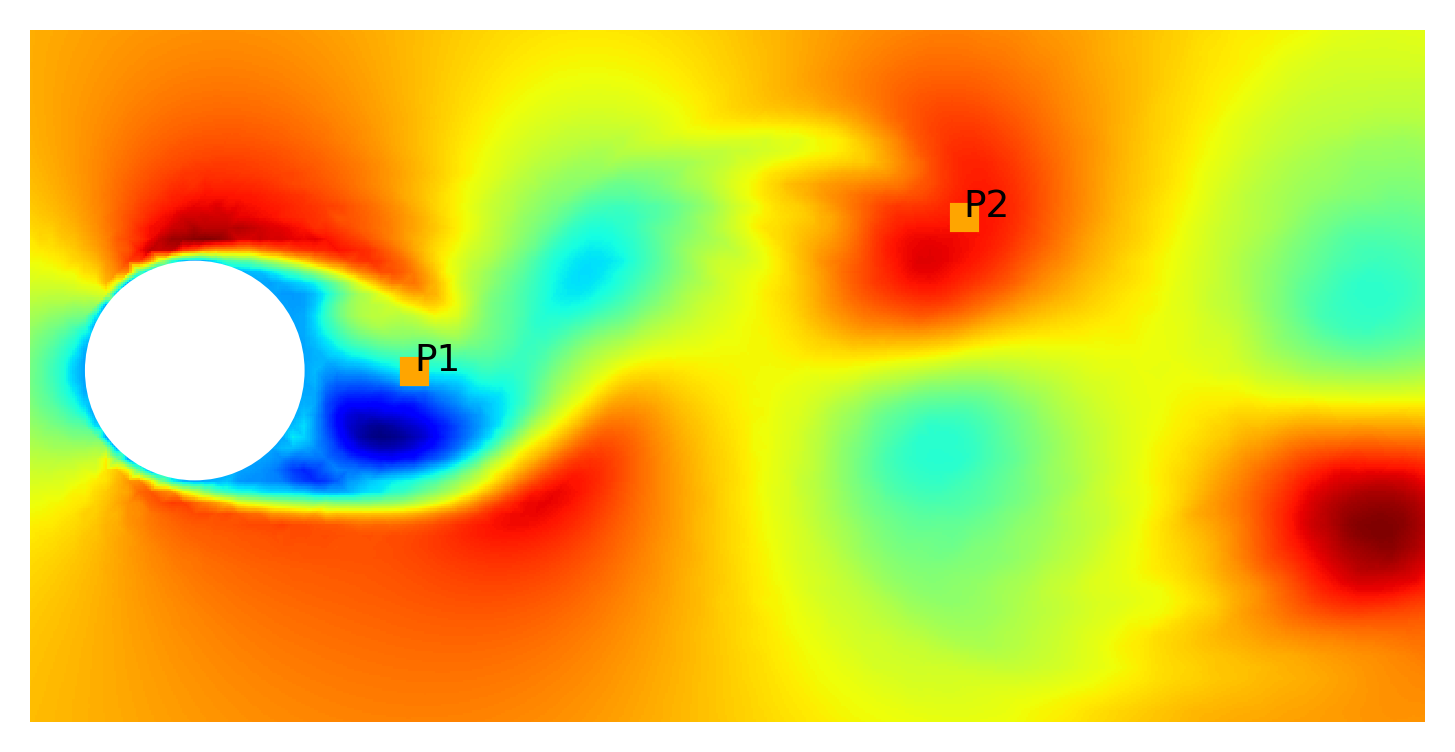

In [ ]:
xmax,xmin,ymax,ymin=limit[0],limit[1],limit[2],limit[3]


dx, dy = 0.01, 0.01
# dx, dy = 0.01, 0.01
Nx = int((xmax-xmin)/dx+1)
Ny = int((ymax-ymin)/dy+1)
x = np.linspace(xmin, xmax, Nx)
y = np.linspace(ymin, ymax, Ny)
x_mesh, y_mesh = np.meshgrid(x, y)

# 插值
grid1 = griddata(coordinates_orig,value,(x_mesh,y_mesh), method='linear', fill_value=0)

# 绘图
ddx = 0.5*(x[2]-x[1])
xca = np.linspace(x[0]-ddx, x[len(x)-1]+ddx, len(x)+1)
ddy = 0.5*(y[2]-y[1])
yca = np.linspace(y[0]-ddy, y[len(y)-1]+ddy, len(y)+1)
# vim = [-0.2,1.4]

# 创造画布
fit = plt.figure(dpi=300,figsize=(6,4))
ax = plt.axes()
# 坐标轴设置
plt.gca().set_aspect('equal')
plt.axis([xmin,xmax,ymin,ymax])
plt.xticks([])
plt.yticks([])
# cmp参数设置
if cmp==None:
  cmp='viridis'  # 'jet'
# 颜色范围设置
if vml==None:
  plt.pcolor(xca,yca,grid1[:,:],cmap=cmp)
else:
  plt.pcolor(xca,yca,grid1[:,:],cmap=cmp,vmin=vml[0],vmax=vml[1])
plt.xticks(fontsize=fs1-5); plt.yticks(fontsize=fs1-5)  #
if cylinder_num==1:
  # 画黑色的圆边界
  # cx1=np.linspace(8.5,9.5,100)
  # cy1=np.sqrt(0.25-(cx1-9)**2)
  # cx2=np.linspace(9.5,8.5,100)
  # cy2=-np.sqrt(0.25-(cx1-9)**2)
  # circx=np.concatenate([cx1,cx2])
  # circy=np.concatenate([cy1,cy2])
  # plt.plot(circx,circy,color='black',linewidth=1)
  # 在圆部分填充灰色
  c = patches.Circle(xy=(9, 0), radius=0.5, fc='white')
  ax.add_patch(c)
elif cylinder_num==3:
  # 加圆柱
  r=0.5
  # 第一个圆
  rx, ry = 4.23, 0.8
  cx11=np.linspace(rx-r,rx+r,100)
  cy11=np.sqrt(r*r-(cx11-rx)**2)+ry
  cx12=np.linspace(rx+r,rx-r,100)
  cy12=-np.sqrt(r*r-(cx12-rx)**2)+ry
  circx=np.concatenate([cx11,cx12])
  circy=np.concatenate([cy11,cy12])
  plt.plot(circx,circy,color='black',linewidth=1)
  c1 = patches.Circle(xy=(rx, ry), radius=r, fc='grey', ec='k')
  ax.add_patch(c1)
  # 第二个圆
  rx, ry = 4.23, -0.8
  cx21=np.linspace(rx-r,rx+r,100)
  cy21=np.sqrt(r*r-(cx21-rx)**2)+ry
  cx22=np.linspace(rx+r,rx-r,100)
  cy22=-np.sqrt(r*r-(cx22-rx)**2)+ry
  circx=np.concatenate([cx21,cx22])
  circy=np.concatenate([cy21,cy22])
  plt.plot(circx,circy,color='black',linewidth=1)
  c2 = patches.Circle(xy=(rx, ry), radius=r, fc='grey', ec='k')
  ax.add_patch(c2)
  # 第三个圆
  rx, ry = 3.0, 0.0
  cx31=np.linspace(rx-r,rx+r,100)
  cy31=np.sqrt(r*r-(cx31-rx)**2)+ry
  cx32=np.linspace(rx+r,rx-r,100)
  cy32=-np.sqrt(r*r-(cx32-rx)**2)+ry
  circx=np.concatenate([cx31,cx32])
  circy=np.concatenate([cy31,cy32])
  plt.plot(circx,circy,color='black',linewidth=1)
  c3 = patches.Circle(xy=(rx, ry), radius=r, fc='grey', ec='k')
  ax.add_patch(c3)
elif cylinder_num==2:
  # 加圆柱
  r=0.1
  # 第一个圆
  rx, ry = 1.7, 1.0
  cx11=np.linspace(rx-r,rx+r,100)
  cy11=np.sqrt(r*r-(cx11-rx)**2)+ry
  cx12=np.linspace(rx+r,rx-r,100)
  cy12=-np.sqrt(r*r-(cx12-rx)**2)+ry
  circx=np.concatenate([cx11,cx12])
  circy=np.concatenate([cy11,cy12])
  plt.plot(circx,circy,color='black',linewidth=1)
  c1 = patches.Circle(xy=(rx, ry), radius=r, fc='grey', ec='k')
  ax.add_patch(c1)
  # 第二个圆
  rx, ry = 2.3, 1.0
  # cx21=np.linspace(rx-r,rx+r,100)
  # cy21=np.sqrt(r*r-(cx21-rx)**2)+ry
  # cx22=np.linspace(rx+r,rx-r,100)
  # cy22=-np.sqrt(r*r-(cx22-rx)**2)+ry
  # circx=np.concatenate([cx21,cx22])
  # circy=np.concatenate([cy21,cy22])
  # plt.plot(circx,circy,color='black',linewidth=1)
  c2 = patches.Circle(xy=(rx, ry), radius=r, fc='white')
  ax.add_patch(c2)
# plt.plot([1025,1025],[-2,2],'k',lw=0.5)
# plt.plot([1.6,1.6],[-3,3],'k',lw=0.5)
# plt.plot([1.89895505], [1.00459325], marker='s')
plt.plot([10.0], [0.0], marker='s',color='orange')
plt.text(10.0, 0.0, 'P1',fontsize=9, color='k',weight='light')
plt.plot([12.5], [0.7], marker='s',color='orange')
plt.text(12.5, 0.7, 'P2',fontsize=9, color='k',weight='light')
plt.axis('off')
plt.show()

## 2 ROM-POD

### 2.1 POD



In [ ]:
n_ts = 2000

X = np.zeros((n_ts,Nx,Ny,2))
Xrall = np.zeros((n_ts,Nx,Ny,2))
X[:,:,:,0] = Un[1000:1000+n_ts,:,:]
X[:,:,:,1] = Vn[1000:1000+n_ts,:,:]
# X = X[1000:,:,:,:]
print('X',X.shape)

X_avg = np.mean(X,axis=0)
for i in range(len(Xrall)):
  Xrall[i,:,:,:] = X[i,:,:,:] - X_avg

X (2000, 128, 64, 2)


In [ ]:
n_ts = 2000

X = np.zeros((n_ts,Nx,Ny))
Xrall = np.zeros((n_ts,Nx,Ny))
X[:,:,:] = Un[-n_ts:,:,:]
# X[:,:,:] = Un[1000:1000+n_ts,:,:]
# X[:,:,:,1] = Vn[1000:1000+n_ts,:,:]
# X = X[1000:,:,:,:]
print('X',X.shape)

X_avg = np.mean(X,axis=0)
for i in range(len(Xrall)):
  Xrall[i,:,:] = X[i,:,:] - X_avg

X (2000, 128, 64)


In [ ]:

k = 3 # POD latent vector

Xr = cp(Xrall[-n_ts:,:,:])
Xr = Xr.reshape((len(Xrall),Nx*Ny))

pca1 = PCA(n_components=k)
Xr_reduce = pca1.fit_transform(Xr)

print(Xr_reduce.shape)  # (ts,new_fea)
print(pca1.explained_variance_)
print(pca1.explained_variance_ratio_)

sum = 0
for i in range(0,len(pca1.explained_variance_ratio_)):
  sum += pca1.explained_variance_ratio_[i]
print(sum)

(2000, 3)
[264.74639477 230.60132522  14.22854228]
[0.49792711 0.43370808 0.02676062]
0.9583958052831799


In [ ]:
comp = pca1.components_
# print(comp.shape)  # Pk
re_Xr_pca = np.dot(Xr_reduce,comp)
# print(re_Xr_pca.shape)
# print(pca1.explained_variance_ratio_)



Xr = Xr.reshape((len(Xr),Nx,Ny))
re_Xr_pca = re_Xr_pca.reshape((len(Xr_reduce),Nx,Ny))
ratio = 1-np.linalg.norm(re_Xr_pca-Xr)/np.linalg.norm(Xr)  # 还原率
print(ratio)


re_Xr = np.zeros_like(re_Xr_pca)
for i in range(len(re_Xr)):
  re_Xr[i,:,:] = re_Xr_pca[i,:,:] + X_avg
ratio = 1-np.linalg.norm(re_Xr-X)/np.linalg.norm(X)  # 还原率
print(ratio)

In [ ]:

kk = 10
ratio_nomode0 = np.zeros((10,2))
ratio_mode0 = np.zeros((10,2))
for k in range(kk):
# k = 5 # POD latent vector
  print("k=",k)
  Xr = cp(Xrall)
  Xr = Xr.reshape((len(Xrall),Nx*Ny))
  ratio_nomode0[k,0] = k
  ratio_mode0[k,0] = k

  pca1 = PCA(n_components=k)
  Xr_reduce = pca1.fit_transform(Xr)

  # print(Xr_reduce.shape)  # (ts,new_fea)
  # print(pca1.explained_variance_)
  # print(pca1.explained_variance_ratio_)

  sum = 0
  for i in range(0,len(pca1.explained_variance_ratio_)):
    sum += pca1.explained_variance_ratio_[i]
  # print(sum)


  comp = pca1.components_
  # print(comp.shape)  # Pk
  re_Xr_pca = np.dot(Xr_reduce,comp)
  # print(re_Xr_pca.shape)



  Xr = Xr.reshape((len(Xr),Nx,Ny))
  re_Xr_pca = re_Xr_pca.reshape((len(Xr_reduce),Nx,Ny))
  ratio = 1-np.linalg.norm(re_Xr_pca-Xr)/np.linalg.norm(Xr)  # 还原率
  print(ratio)
  ratio_nomode0[k,1] = ratio

  re_Xr = np.zeros_like(re_Xr_pca)
  for i in range(len(re_Xr)):
    re_Xr[i,:] = re_Xr_pca[i,:] + X_avg
  ratio = 1-np.linalg.norm(re_Xr-X)/np.linalg.norm(X)  # 还原率
  print(ratio)
  ratio_mode0[k,1] = ratio

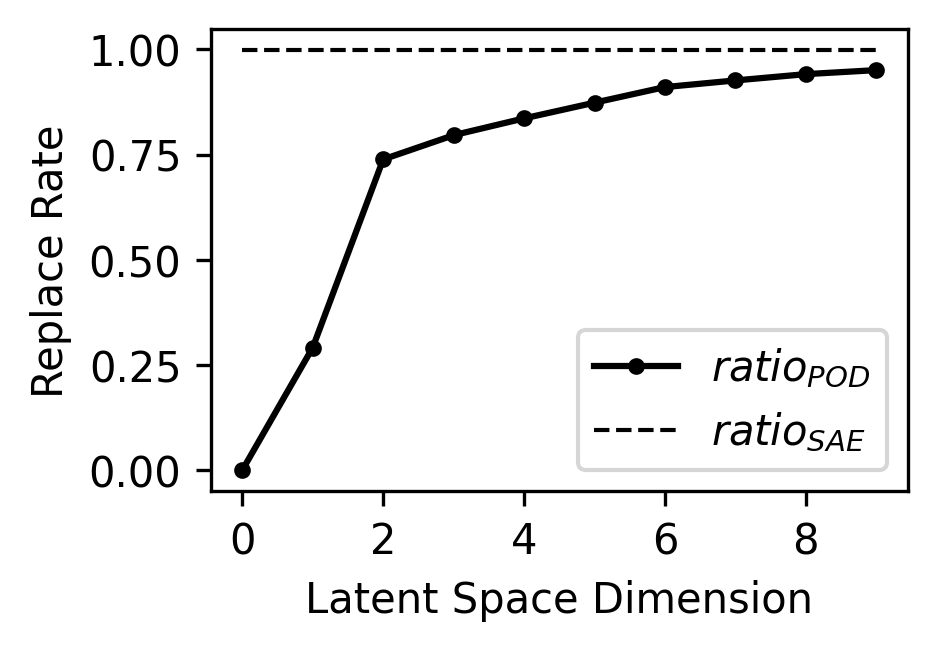

In [ ]:
k_dim = np.arange(kk)
plt.figure(dpi=300,figsize=(3,2))
# plt.scatter(k_dim,ratio_mode0,marker='o', c=totalnum[noerror], cmap='tab20', label='Amplitude',vmin=-0.5, vmax=19.5)
# plt.scatter(k_dim, ratio_mode0[:,1], marker='o', cmap='tab20', label='ratio(POD,no mode0)',vmin=-0.5, vmax=19.5)
plt.plot(k_dim, ratio_nomode0[:,1],'k.-',label=r'$ratio_{POD}$')
# plt.plot(k_dim, ratio_mode0[:,1],'.-',label=r'$ratio2_{POD}$')
# plt.plot(alr_ne, err_st, 'k.-',label='Frequency')
plt.ylabel('Replace Rate')
plt.xlabel('Latent Space Dimension')
# plt.ylabel('Error rate', fontsize=fonts1)
# plt.xlabel(r'$\alpha$', fontsize=fonts1)
# plt.xscale('log')
x0 = 9
y0 = 0.9980481688131074
# y1 = 0.9959166493103554
plt.plot([0,x0],[y0,y0],'k--',lw=1,label=r'$ratio_{SAE}$')
# plt.plot([0,x0],[y1,y1],'b--',lw=0.5,label=r'$ratio2_{SAE}$')

plt.legend(loc='lower right')

# filename = "/content/drive/MyDrive/fig/1cylinder/replace_rate_comparison.png"
# plt.savefig(filename,bbox_inches='tight')

In [ ]:
#
r1 = Xr_reduce[:,0]
r2 = Xr_reduce[:,1]
r3 = Xr_reduce[:,2]
# r4 = Xr_reduce[:,3]
# r5 = Xr_reduce[:,4]
# r4 = Xrall_pca_reduce[:,3]
# r5 = Xrall_pca_reduce[:,4]
# r6 = Xrall_pca_reduce[:,5]

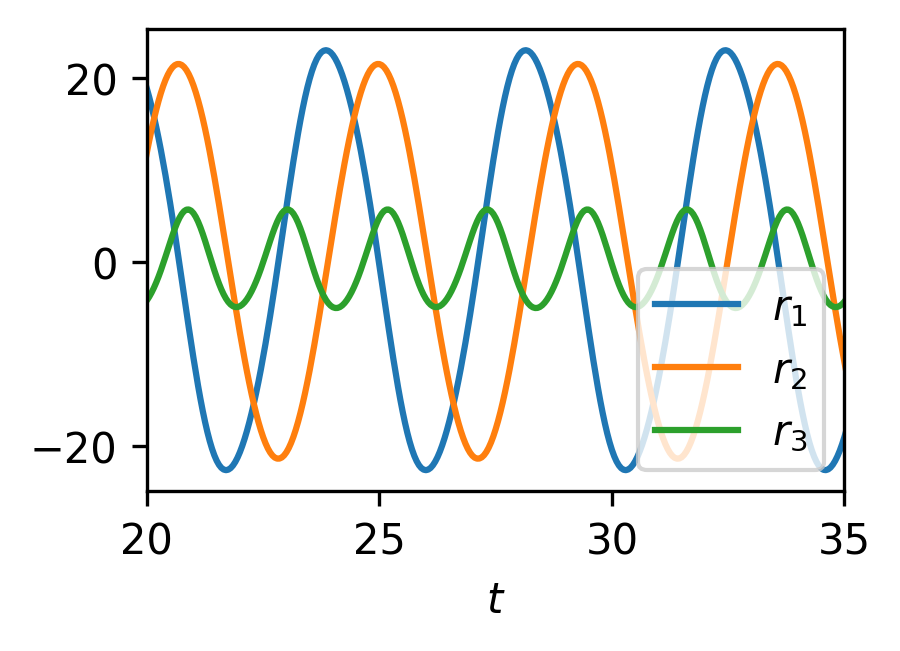

In [ ]:
fig=plt.figure(dpi=300,figsize=(3,2))
plt.plot(tax,r1[2:],label=r'$r_1$')
plt.plot(tax,r2[2:],label=r'$r_2$')
plt.plot(tax,r3[2:],label=r'$r_3$')
# plt.plot(tax,r4[2:],label=r'$r_4$')
# plt.plot(tax,r5[2:],label=r'$r_5$')
# plt.plot(tax,r6[2:],label=r'$r_6$')
# plt.xlim([30,60])
plt.xlim([20,35])
plt.legend(loc='lower right') #,fontsize=12)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.xlabel(r'$t$',fontsize=20)
plt.xlabel(r'$t$')
# plt.ylabel(r'Value',fontsize=20)
# plt.ylim([-50,50])
# plt.savefig("/content/drive/MyDrive/fig/1cylinder/1c_pod_latent1.png",bbox_inches='tight')
plt.show()

In [ ]:
print(np.max(xn),np.min(xn))
print(np.max(yn),np.min(yn))

14.600000000000001 8.25
1.5500000000000007 -1.5999999999999996


## 3 AutoEncoder build

In [ ]:
import pandas as pd
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Add, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import os, sys
import urllib.request
from keras.models import load_model
import pickle
import copy, h5py
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy as cp

from copy import deepcopy as cp
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
n_ts = 2000 #2000
X = np.zeros((n_ts,Nx,Ny))
# X_avg = np.zeros((Nx,Ny,2))
X[:,:,:] = Un[-n_ts:,:,:]
# X[:,:,:,1] = Vn[-n_ts:,:,:]

In [ ]:
y_coor, x_coor = np.meshgrid(yn,xn)
coor = np.zeros((128,64,2))
coor[:,:,0] = x_coor
coor[:,:,1] = y_coor

n=0
for i in range(Nx):
  for j in range(Ny):
    if (coor[i,j,0]-9)**2+coor[i,j,1]**2<=0.25:
      n+=1
      for k in range(n_ts):
        X[k,i,j] = 0
        # X[k,i,j,1] = 0
print(n)

311


In [ ]:
X_avg = np.mean(X,axis=0)


Xrall = np.zeros((n_ts,Nx,Ny))
for i in range(0,n_ts):
  Xrall[i,:,:] = X[i,:,:]-X_avg
Xrall_sae = cp(Xrall)

In [ ]:

X0_sae = cp(Xrall_sae)


min = np.min(X0_sae,axis=0)
max = np.max(X0_sae,axis=0)
# X0_sae = (X0_sae-min)/(max-min)
X0_sae = X0_sae-min

# print(np.max(X0_sae[:,:,:,0]))
# print(np.max(X0_sae[:,:,:,1]))
# print(np.min(X0_sae[:,:,:,0]))
# print(np.min(X0_sae[:,:,:,1]))


# for k in range(n_ts):
#   for i in range(Nx):
#     for j in range(Ny):
#       for u in range(2):
#         if np.isnan(X0_sae[k,i,j,u]):
#           X0_sae[k,i,j,u] = 0

print(np.max(X0_sae))
print(np.min(X0_sae))

print(X0_sae.shape)

2.0590101200385185
0.0
(2000, 128, 64)


In [ ]:
model_name = './sae_u_2000_relu_version.hdf5'
input_dim = 128*64
layer_dim = [64*16,16*8,10*4,15,2]
latent_dim = 2
active = 'relu'

autoencoder_sae = build_autoencoder(input_dim, layer_dim, active)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8192)]            0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 40)                5160      
                                                                 
 dense_3 (Dense)             (None, 15)                615       
                                                                 
 dense_4 (Dense)             (None, 2)                 32        
                                                                 
 dense_5 (Dense)             (None, 15)                45    

In [ ]:
X0_sae = X0_sae.reshape((len(X0_sae),128*64))

In [ ]:
filename_ae='sae_u_2000_relu_version' # File name of this model
train_network(autoencoder_sae, filename_ae, X0_sae)

Epoch 1/200
136/140 [============================>.] - ETA: 0s - loss: 0.0557
Epoch 1: val_loss improved from inf to 0.03344, saving model to ./sae_u_2000_relu_version.hdf5
140/140 [==============================] - 16s 18ms/step - loss: 0.0552 - val_loss: 0.0334
Epoch 2/200
137/140 [============================>.] - ETA: 0s - loss: 0.0237
Epoch 2: val_loss improved from 0.03344 to 0.00896, saving model to ./sae_u_2000_relu_version.hdf5
140/140 [==============================] - 2s 16ms/step - loss: 0.0235 - val_loss: 0.0090
Epoch 3/200
138/140 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 3: val_loss improved from 0.00896 to 0.00113, saving model to ./sae_u_2000_relu_version.hdf5
140/140 [==============================] - 2s 15ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 4/200
135/140 [===========================>..] - ETA: 0s - loss: 8.1301e-04
Epoch 4: val_loss improved from 0.00113 to 0.00043, saving model to ./sae_u_2000_relu_version.hdf5
140/140 [============

In [ ]:
autoencoder_sae = load_autoencoder(model_name, input_dim, latent_dim)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8192)]            0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 40)                5160      
                                                                 
 dense_3 (Dense)             (None, 15)                615       
                                                                 
 dense_4 (Dense)             (None, 2)                 32        
                                                                 
 dense_5 (Dense)             (None, 15)                45    

In [ ]:
# X0_sae = X0_sae.reshape((n_ts,Nx,Ny))

#### RATE

In [ ]:
pod_rate = 0.931528803916728 # 0.7385333447227476
sea_relu_rate = 0.9959166493103554
sea_tanh_rate = 0.9683367228084818
sae_sigmoid_rate = 0.9276856164407066
pod_sindy_rate = 0.913634263065336
sae_sindy_rate = 0.9645324290484394

In [ ]:
T = np.arange(400)
R1 = np.repeat(pod_rate,len(T))
R2 = np.repeat(sea_relu_rate,len(T))
R3 = np.repeat(sea_tanh_rate,len(T))
R4 = np.repeat(sae_sigmoid_rate,len(T))
R5 = np.repeat(pod_sindy_rate,len(T))
R6 = np.repeat(sae_sindy_rate,len(T))
R7 = np.repeat(1,len(T))

Text(0.5, 1.0, 'Rate')

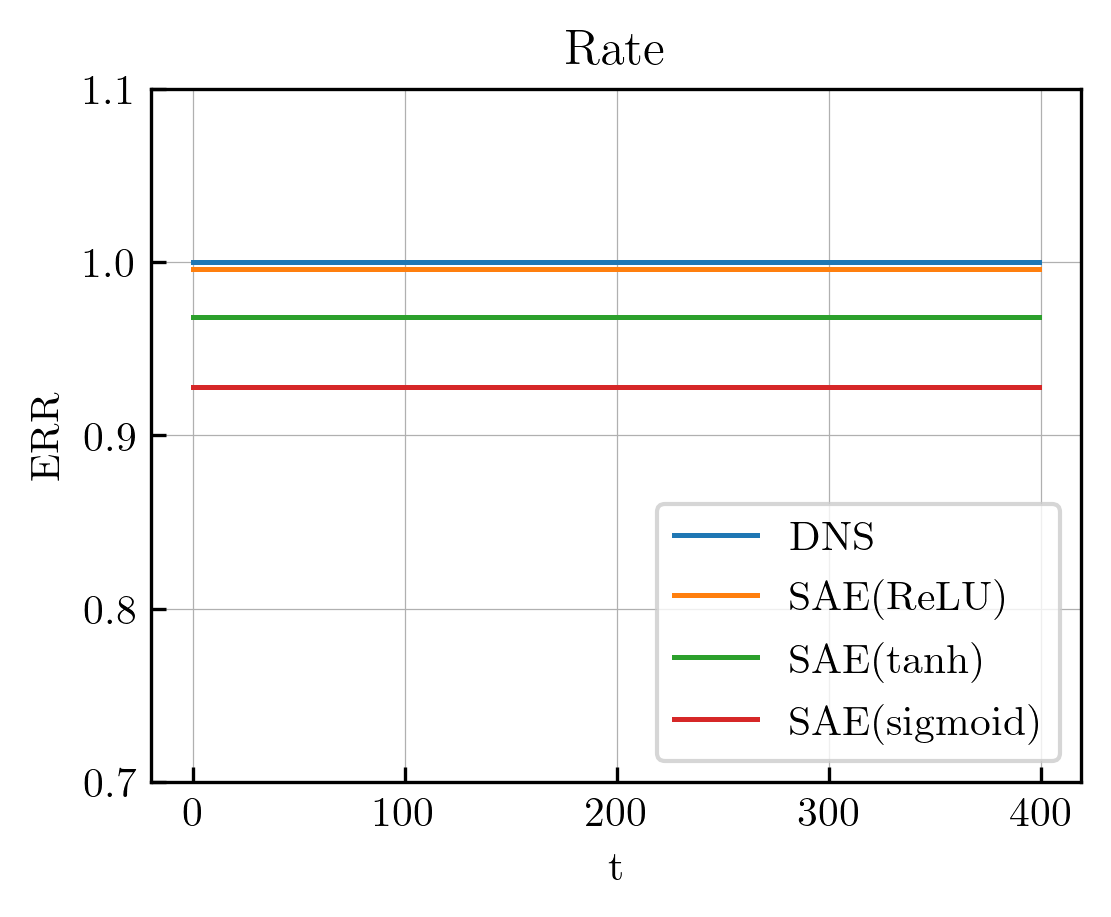

In [ ]:
plt.figure(dpi=300,figsize=(4,3))
# DNS=1
plt.plot(T,R7,'-',lw=1.2,label='DNS')
# plt.plot(T,R1,'-',lw=1.2,label='pod_rate')
plt.plot(T,R2,'-',lw=1.2,label='SAE(ReLU)')
plt.plot(T,R3,'-',lw=1.2,label='SAE(tanh)')
plt.plot(T,R4,'-',lw=1.2,label='SAE(sigmoid)')
# plt.plot(T,R5,'-',lw=1.2,label='pod_sindy_rate')
# plt.plot(T,R6,'-',lw=1.2,label='sae_sindy_rate')

plt.ylabel('ERR')
plt.xlabel('t') #,fontsize=8)

plt.yticks([0.7,0.8,0.9,1.0,1.1])

plt.legend(loc='lower right')

plt.grid(lw=0.3)

plt.title('Rate') #,fontsize=8)

Text(0.5, 1.0, 'Rate')

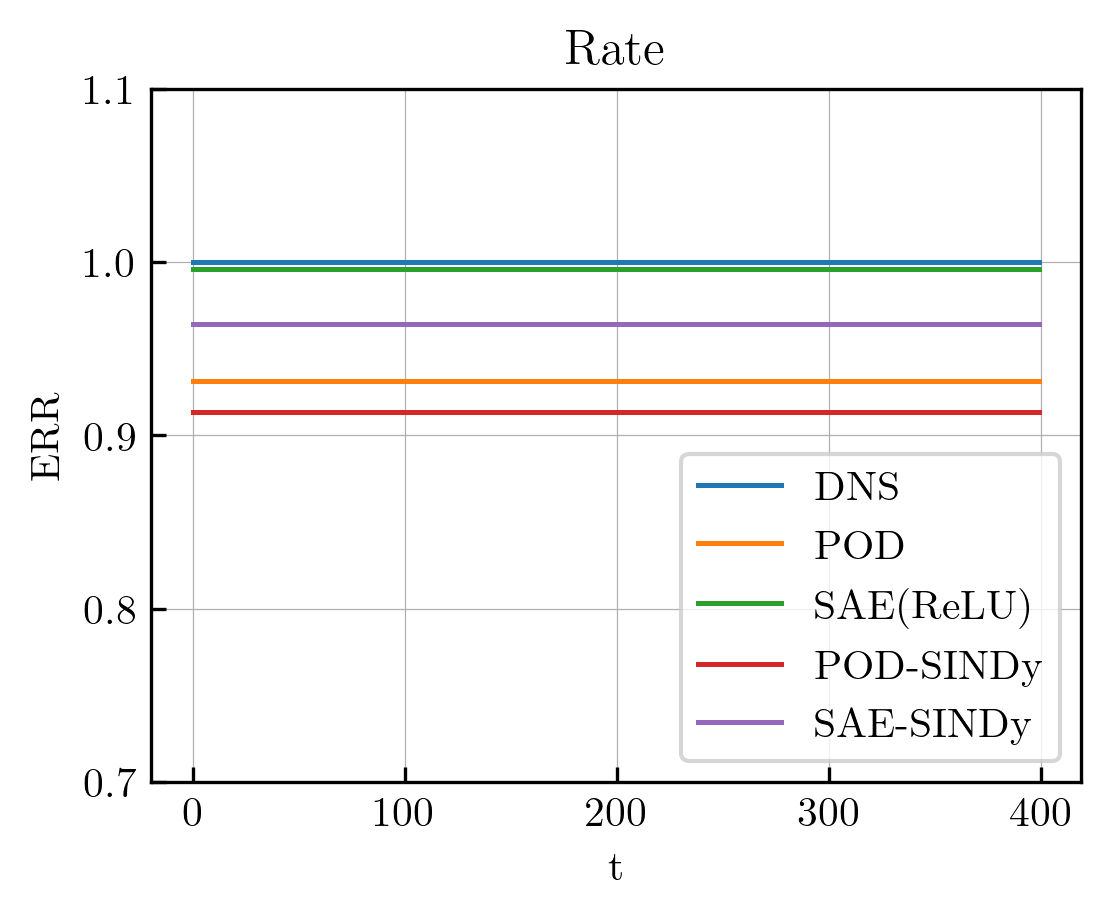

In [ ]:
plt.figure(dpi=300,figsize=(4,3))
# DNS=1
plt.plot(T,R7,'-',lw=1.2,label='DNS')
plt.plot(T,R1,'-',lw=1.2,label='POD')
plt.plot(T,R2,'-',lw=1.2,label='SAE(ReLU)')
# plt.plot(T,R3,'-',lw=1.2,label='SAE(tanh)')
# plt.plot(T,R4,'-',lw=1.2,label='SAE(sigmoid)')
plt.plot(T,R5,'-',lw=1.2,label=r'POD-SINDy')
plt.plot(T,R6,'-',lw=1.2,label='SAE-SINDy')

plt.ylabel('ERR')
plt.xlabel('t') #,fontsize=8)

plt.yticks([0.7,0.8,0.9,1.0,1.1],fontsize=10)

plt.legend(loc='lower right')

plt.grid(lw=0.3)

plt.title('Rate') #,fontsize=8)

Text(0.5, 1.0, 'Rate')

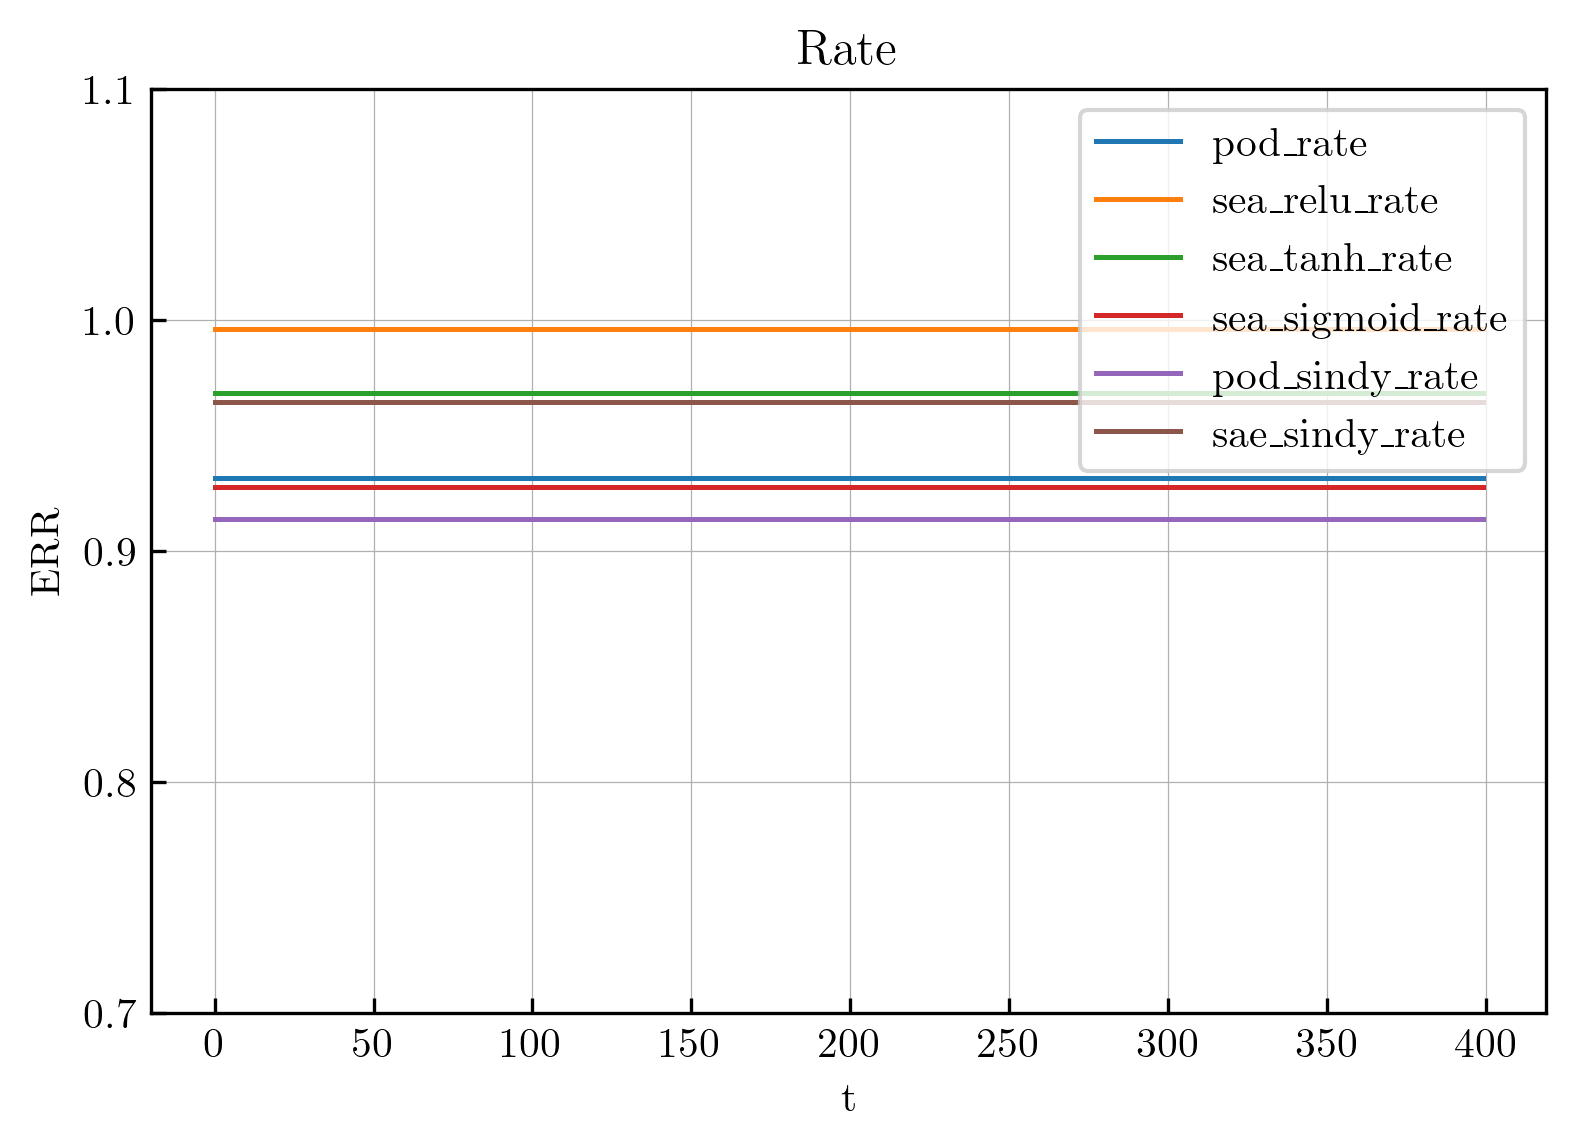

In [ ]:
plt.figure(dpi=300,figsize=(6,4))
# DNS=1
plt.plot(T,R1,'-',lw=1.2,label='pod_rate')
plt.plot(T,R2,'-',lw=1.2,label='sea_relu_rate')
plt.plot(T,R3,'-',lw=1.2,label='sea_tanh_rate')
plt.plot(T,R4,'-',lw=1.2,label='sea_sigmoid_rate')
plt.plot(T,R5,'-',lw=1.2,label='pod_sindy_rate')
plt.plot(T,R6,'-',lw=1.2,label='sae_sindy_rate')

plt.ylabel('ERR')
plt.xlabel('t') #,fontsize=8)

plt.yticks([0.7,0.8,0.9,1.0,1.1])

plt.legend(loc='upper right')

plt.grid(lw=0.3)

plt.title('Rate') #,fontsize=8)

In [ ]:

plt.figure(dpi=300,figsize=(4,3))
plt.plot(T,)

plt.plot(loss_data1[:,2], loss_data1[:,1],'-',lw=1.2,label='ReLU')
# plt.plot(loss_data2[:,2], loss_data2[:,0],'-',lw=0.5,label=r'loss')
plt.plot(loss_data2[:,2], loss_data2[:,1],'-',lw=1.2,label='tanh')
# plt.plot(loss_data3[:,2], loss_data3[:,0],'-',lw=0.5,label=r'loss')
plt.plot(loss_data3[:,2], loss_data3[:,1],'-',lw=1.2,label='sigmoid')
plt.ylabel('val-loss')
plt.xlabel('epoch') #,fontsize=8)
plt.yticks([0,0.02,0.04,0.06,0.08]) #,fontsize=15)
# plt.xlim([-10,210])
# # plt.ylim([-0.005,0.08])
plt.legend()

plt.grid(lw=0.3)

plt.title('Comparision of acvitation functions') #,fontsize=8)